In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, r2_score


In [141]:
class GCN(layers.Layer):
    """
    A graph convolution model
    """
    def __init__(self, output_dim, inputs=[x, y], **kwargs):
        self.output_dim = output_dim
        super(GCN, self).__init__(**kwargs)

    def build(self, input_shape):
        print(input_shape[0][2])
        shape = tf.TensorShape((input_shape[0][2], self.output_dim))
        shape = [int(shape[0]),int(shape[1])] # [50 , 32]

        self.kernel = self.add_weight(name='kernel',
                                  shape=shape,
                                  initializer='glorot_uniform',
                                  trainable=True,dtype=tf.float32)

        self.bias = self.add_weight(name='bias',
                        shape=[shape[1]],
                        initializer='glorot_uniform',
                        trainable=True,dtype=tf.float32)

    def call(self, input):
        X, A = input[0], input[1]
        dim = self.kernel.get_shape()[1]
        num_atoms = A.get_shape()[1]
        _b = tf.reshape(tf.tile(self.bias, [num_atoms]), [num_atoms, dim])
        _X = tf.einsum('ijk,kl->ijl', X, self.kernel) + _b
        #_X = get_skip_connection(_X, X)
        return _X

class G2N(layers.Layer):
    """
    A layer to sum the node feature to preserve the permutation invariance
    """
    def __init__(self, output_dim,  **kwargs):
        self.output_dim = output_dim
        super(G2N, self).__init__(**kwargs)

    def build(self, input_shape):
        shape = tf.TensorShape((input_shape[2], self.output_dim))
        shape = [int(shape[0]),int(shape[1])] # [50 , 32]

        self.kernel = self.add_weight(name='kernel',
                                  shape=shape,
                                  initializer='glorot_uniform',
                                  trainable=True,dtype=tf.float32)

    def call(self, X):
        #print(X.get_shape())
        #print(self.kernel.get_shape())
        Z = tf.einsum('ijk,kl->ijl', X, self.kernel)
        Z = tf.nn.relu(Z)
        Z = tf.nn.sigmoid(tf.reduce_sum(Z, 1))
        return Z

class mymodel(tf.keras.Model):
    """
    A generallized model for the prediction of properties from graph
    """
    def __init__(self):#, inputs=[x, y]):
        super(mymodel, self).__init__(name='')
        self.gcn1 = GCN(32) #, input_shape=[58])
        #self.gcn2 = GCN(32) #, input_shape=[58])
        self.gcn3 = GCN(32) #, input_shape=[58])
        self.g2n = G2N(64)#, input_shape=[58])
        self.dense1 = layers.Dense(64, activation=tf.nn.relu, input_shape=[64])
        self.dense2 = layers.Dense(64, activation=tf.nn.relu, input_shape=[64])
        self.dense3 = layers.Dense(1)

    def call(self, input):
        X, A = input[0], input[1]
        x = tf.nn.relu(self.gcn1([X, A]))
        #x = tf.nn.relu(self.gcn2(x))
        x = tf.nn.relu(self.gcn3([x, A]))
        x = tf.nn.relu(self.g2n(x))
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)
    
def load_data(path="../data/", ids=10000):
    """
    load the source data from somewhere
    """
    features = np.load(path+'f-fea.npy')[:ids]
    adj = np.load(path+'f-adj.npy')[:ids]
    prop = np.load(path+'f-prop.npy')[:ids]
    #features = np.reshape(features, [ids, features.shape[1]*features.shape[2]])
    return adj, features, prop

class Progress(keras.callbacks.Callback):
    """
    A simple function to show the progress
    """
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0:
             print('epoch-----', epoch, logs)

In [137]:
adj, features, props = load_data()
print('shape of feature: ', np.shape(features))
model = mymodel()
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])
input = {'input_1': features, 'input_2': adj}
#model.fit(x=input, y=props, batch_size=50, verbose=1, validation_split=0.1)
history = model.fit(x=[features, adj], y=props, batch_size=500, 
                    epochs=1000, validation_split=0.1, verbose=0,
                    allbacks=[Progress()]
                   )
#history = model.fit(x=features, y=props, epochs=100, batch_size=50, verbose=0, validation_split=0.1)

shape of feature:  (10000, 50, 58)
58
32


In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gcn_22 (GCN)                 multiple                  1888      
_________________________________________________________________
gcn_23 (GCN)                 multiple                  1056      
_________________________________________________________________
g2n_31 (G2N)                 multiple                  2048      
_________________________________________________________________
dense_100 (Dense)            multiple                  4160      
_________________________________________________________________
dense_101 (Dense)            multiple                  4160      
_________________________________________________________________
dense_102 (Dense)            multiple                  65        
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________


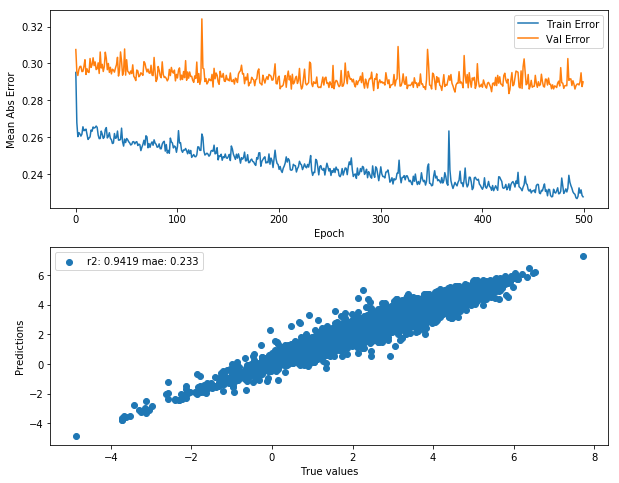

In [154]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(hist['epoch'], hist['mean_absolute_error'],
         label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
         label = 'Val Error')
plt.legend()

plt.subplot(212)
res = model.predict([features,adj]).flatten()
r2 = 'r2: {:.4f} '.format(r2_score(res, props))
mae = 'mae: {:.3f}'.format(mean_absolute_error(res, props))
plt.scatter(props, res, label=r2+mae)
plt.legend()
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.show()


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])

history = model.fit(x=[features, adj], y=props, batch_size=500, 
                    epochs=500, validation_split=0.1, verbose=0,
                    callbacks=[Progress()]
                   )

epoch----- 0 {'val_loss': 0.2954017221927643, 'val_mean_absolute_error': 0.2954017221927643, 'val_mean_squared_error': 0.15952619910240173, 'loss': 0.25966202053758836, 'mean_absolute_error': 0.25966202053758836, 'mean_squared_error': 0.12756998878386286}
epoch----- 10 {'val_loss': 0.2913236916065216, 'val_mean_absolute_error': 0.2913236916065216, 'val_mean_squared_error': 0.1535898968577385, 'loss': 0.23003804104195702, 'mean_absolute_error': 0.23003804104195702, 'mean_squared_error': 0.10806848398513264}
epoch----- 20 {'val_loss': 0.2911025285720825, 'val_mean_absolute_error': 0.2911025285720825, 'val_mean_squared_error': 0.15604908764362335, 'loss': 0.23014974428547752, 'mean_absolute_error': 0.23014974428547752, 'mean_squared_error': 0.10742890338102977}
epoch----- 30 {'val_loss': 0.2926923632621765, 'val_mean_absolute_error': 0.2926923632621765, 'val_mean_squared_error': 0.15427397191524506, 'loss': 0.22683102389176688, 'mean_absolute_error': 0.22683102389176688, 'mean_squared_err

epoch----- 320 {'val_loss': 0.2887952923774719, 'val_mean_absolute_error': 0.2887952923774719, 'val_mean_squared_error': 0.1541566550731659, 'loss': 0.22305939346551895, 'mean_absolute_error': 0.22305939346551895, 'mean_squared_error': 0.1012779027223587}
epoch----- 330 {'val_loss': 0.2884846478700638, 'val_mean_absolute_error': 0.2884846478700638, 'val_mean_squared_error': 0.15462853014469147, 'loss': 0.2194803613755438, 'mean_absolute_error': 0.2194803613755438, 'mean_squared_error': 0.10029187964068519}
epoch----- 340 {'val_loss': 0.29018136858940125, 'val_mean_absolute_error': 0.29018136858940125, 'val_mean_squared_error': 0.15858860313892365, 'loss': 0.21938778211673102, 'mean_absolute_error': 0.21938778211673102, 'mean_squared_error': 0.09985814202162954}
epoch----- 350 {'val_loss': 0.2885299474000931, 'val_mean_absolute_error': 0.2885299474000931, 'val_mean_squared_error': 0.1554219201207161, 'loss': 0.21939362419976127, 'mean_absolute_error': 0.21939362419976127, 'mean_squared_